In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Detect_person

Mounted at /content/drive
/content/drive/MyDrive/Detect_person


In [2]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

## Install Ultralytics Package

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

## Visualize Images from the Dataset

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

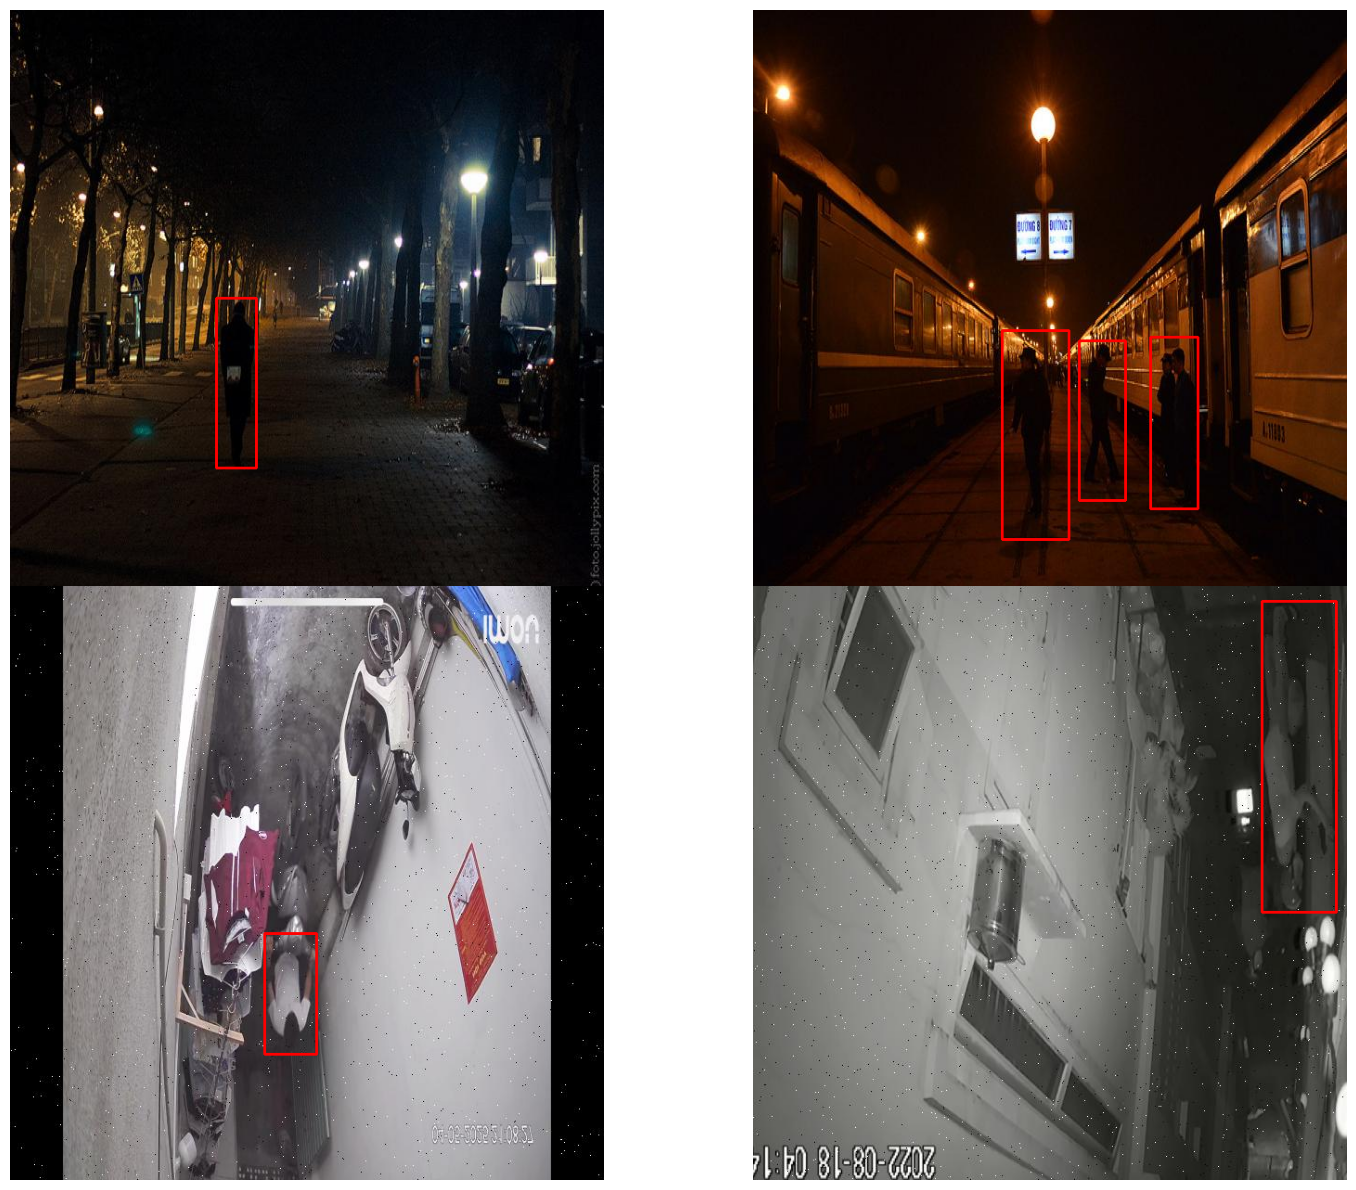

In [ ]:
# Visualize a few training images.
plot(
    image_paths='dataset/train/images/',
    label_paths='dataset/train/labels/',
    num_samples=4,
)

## Dataset YAML File

In [ ]:
%%writefile person.yaml
path: '/content/drive/MyDrive/Detect_person/dataset/'
train: 'train/images'
val: 'valid/images'

# class names
names:
  0: 'person'

Overwriting person.yaml


## YOLOv8 Nano Training

In [ ]:
EPOCHS = 100
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=person.yaml epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=person.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None

## Evaluation on Validation Images

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/Detect_person/runs/detect/yolov8n_v8_50e/weights/best.pt name=yolov8n_eval data=person.yaml

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.5 ms, read: 10.8±6.9 MB/s, size: 29.5 KB)
val: Scanning /content/drive/MyDrive/Detect_person/dataset/valid/labels.cache... 128 images, 1 backgrounds, 0 corrupt: 100% 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:06<00:00,  1.33it/s]
                   all        128        251      0.755      0.622      0.702      0.411
Speed: 13.9ms preprocess, 18.1ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/yolov8n_eval2
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference on Validation Images

In [ ]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8n_v8_50e/weights/best.pt \
source=dataset/valid/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in in the future. Use 'show_labels' instead.
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/128 /content/drive/MyDrive/Detect_person/dataset/valid/images/2015_06267_jpg.rf.177eb9c61f8f20c900795519e931e8fc.jpg: 1280x1280 3 persons, 19.5ms
image 2/128 /content/drive/MyDrive/Detect_person/dataset/valid/images/2015_06269_jpg.rf.1ea2c871f2de9821942585342ded99eb.jpg: 1280x1280 2 persons, 19.8ms
image 3/128 /content/drive/MyDrive/Detect_person/dataset/valid/images/2015_06272_jpg.rf.fe7bd72fa33c7c2f6984bc985e74f483.jpg: 1280x1280 3 persons, 19.4ms
image 4/128 /content/drive/MyDrive/Detect_person/dataset/valid/images/2015_06273_jpg.rf.c559c05b763b5ed9b24e53b70f678306.jpg: 1280x1280 1 person, 19.5ms
image 5/128 /content/drive/MyDrive/Detect_person/dataset/valid/images/2015_06275_jpg.rf.65dfebcf23efde45acf7937e299c1

## Visualize Validation Results

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

In [ ]:
visualize('/content/drive/MyDrive/Detect_person/runs/detect/yolov8n_v8_50e/')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/Detect_person/runs/detect/yolov8n_v8_50e/weights/best.pt source=/content/drive/MyDrive/Detect_person/test_result/IMG_5755.PNG

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/drive/MyDrive/Detect_person/test_result/IMG_5755.PNG: 608x1280 3 persons, 44.4ms
Speed: 8.9ms preprocess, 44.4ms inference, 170.3ms postprocess per image at shape (1, 3, 608, 1280)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
# !yolo task=detect mode=val model=/content/drive/MyDrive/Detect_person/runs/detect/yolov8n_v8_50e/weights/best.pt data=person.yaml
# #